In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [7]:
original_dataset_dir = 'D:\archive (2)\DataSets'
base_dir =r'D:\archive (2)\x-ray'
os.mkdir(base_dir)

In [8]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)


In [9]:
train_covid_dir = os.path.join(train_dir, 'COVID')
os.mkdir(train_covid_dir)

train_pneumonia_dir = os.path.join(train_dir, 'Pneumonia')
os.mkdir(train_pneumonia_dir)

train_lung_opacity_dir = os.path.join(train_dir, 'Lung_Opacity')
os.mkdir(train_lung_opacity_dir)

train_normal_dir = os.path.join(train_dir, 'Normal')
os.mkdir(train_normal_dir)

In [10]:
validation_covid_dir = os.path.join(validation_dir, 'COVID')
os.mkdir(validation_covid_dir)

validation_pneumonia_dir = os.path.join(validation_dir, 'Pneoumonia')
os.mkdir(validation_pneumonia_dir)

validation_lung_opacity_dir = os.path.join(validation_dir, 'Lung_Opacity')
os.mkdir(validation_lung_opacity_dir)

validation_normal_dir = os.path.join(validation_dir, 'Normal')
os.mkdir(validation_normal_dir)

In [2]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    valid_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

In [32]:
COVID_SOURCE_DIR ='D:\\archive (2)\\DataSets\\refined_covid\\'
TRAINING_COVID_DIR = 'D:\\archive (2)\\x-ray\\train\\COVID\\'
VALID_COVID_DIR = 'D:\\archive (2)\\x-ray\\validation\\COVID\\'

PNEUMONIA_SOURCE_DIR ='D:\\archive (2)\\DataSets\\refined_pneumonia\\'
TRAINING_PNEUMONIA_DIR ='D:\\archive (2)\\x-ray\\train\\Pneumonia\\'
VALID_PNEUMONIA_DIR ='D:\\archive (2)\\x-ray\\validation\\Pneumonia\\'

LUNG_OPACITY_SOURCE_DIR ='D:\\archive (2)\\DataSets\\refined_lung_opacity\\'
TRAINING_LUNG_OPACITY_DIR ='D:\\archive (2)\\x-ray\\train\\Lung_Opacity\\'
VALID_LUNG_OPACITY_DIR ='D:\\archive (2)\\x-ray\\validation\\Lung_Opacity\\'

NORMAL_SOURCE_DIR ='D:\\archive (2)\\DataSets\\refined_normal\\'
TRAINING_NORMAL_DIR ='D:\\archive (2)\\x-ray\\train\\Normal\\'
VALID_NORMAL_DIR ='D:\\archive (2)\\x-ray\\validation\\Normal\\'

In [33]:
import os
import random
from shutil import copyfile

split_size = .85

split_data(COVID_SOURCE_DIR, TRAINING_COVID_DIR, VALID_COVID_DIR, split_size)
split_data(PNEUMONIA_SOURCE_DIR, TRAINING_PNEUMONIA_DIR, VALID_PNEUMONIA_DIR, split_size)
split_data(LUNG_OPACITY_SOURCE_DIR, TRAINING_LUNG_OPACITY_DIR, VALID_LUNG_OPACITY_DIR, split_size)
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, VALID_NORMAL_DIR, split_size)

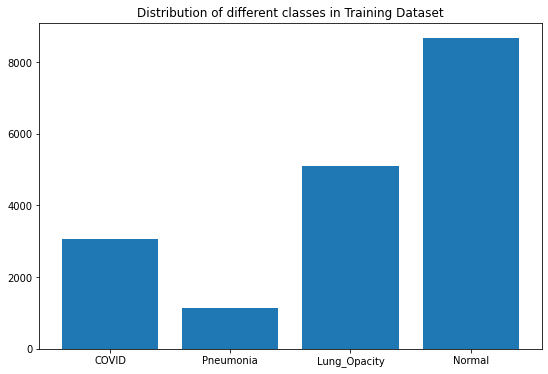

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib

image_folder = ['COVID', 'Pneumonia', 'Lung_Opacity', 'Normal']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('D:\\archive (2)\\x-ray\\train\\'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

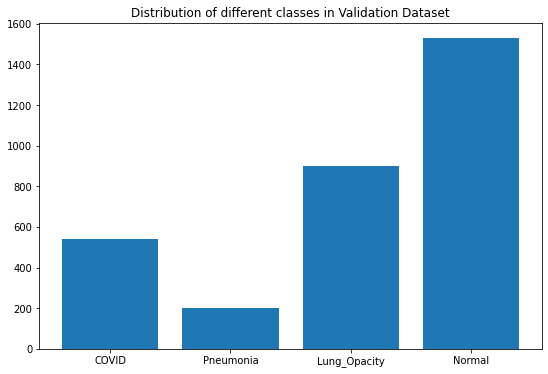

In [36]:
image_folder = ['COVID', 'Pneumonia', 'Lung_Opacity', 'Normal']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('D:\\archive (2)\\x-ray\\validation\\'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Validation Dataset')
plt.show()

In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
img_width=256; img_height=256
batch_size=16

In [39]:
TRAINING_DIR ='D:\\archive (2)\\x-ray\\train\\'

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 17989 images belonging to 4 classes.


In [40]:
VALIDATION_DIR = 'D:\\archive (2)\\x-ray\\validation\\'

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 3176 images belonging to 4 classes.


In [46]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 29, 29, 64)       

In [47]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])

In [48]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# autosave best Model
best_model_file = 'D:\\archive (2)\\x-ray\\best\\'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [49]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model]
                              )

Epoch 1/30
1125/1125 [==============================] - 2170s 2s/step - loss: 1.1209 - accuracy: 0.5238 - val_loss: 0.9918 - val_accuracy: 0.5746
Epoch 2/30
1125/1125 [==============================] - 1372s 1s/step - loss: 0.9100 - accuracy: 0.6269 - val_loss: 0.8875 - val_accuracy: 0.6209
Epoch 3/30
1125/1125 [==============================] - 1826s 2s/step - loss: 0.8373 - accuracy: 0.6570 - val_loss: 0.7552 - val_accuracy: 0.6921
Epoch 4/30
1125/1125 [==============================] - 1651s 1s/step - loss: 0.7836 - accuracy: 0.6776 - val_loss: 0.7054 - val_accuracy: 0.7006
Epoch 5/30
1125/1125 [==============================] - 1483s 1s/step - loss: 0.7542 - accuracy: 0.6920 - val_loss: 0.6707 - val_accuracy: 0.7191
Epoch 6/30
1125/1125 [==============================] - 24552s 22s/step - loss: 0.7368 - accuracy: 0.6995 - val_loss: 0.7041 - val_accuracy: 0.7006
Epoch 7/30
1125/1125 [==============================] - 1781s 2s/step - loss: 0.7198 - accuracy: 0.7038 - val_loss: 0.6594

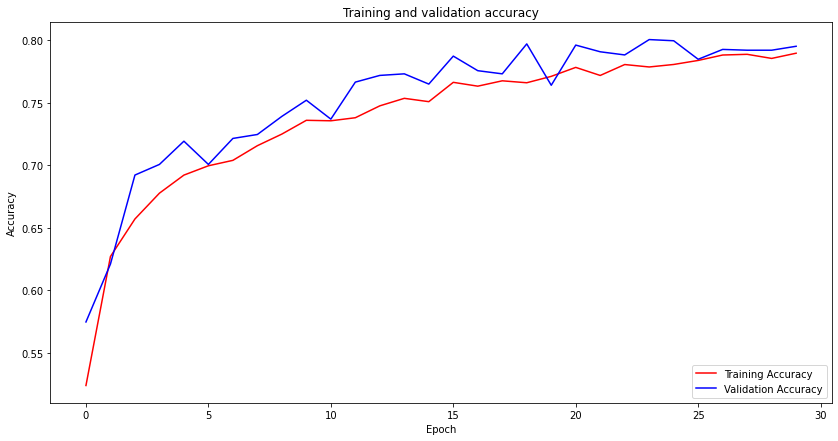

In [50]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

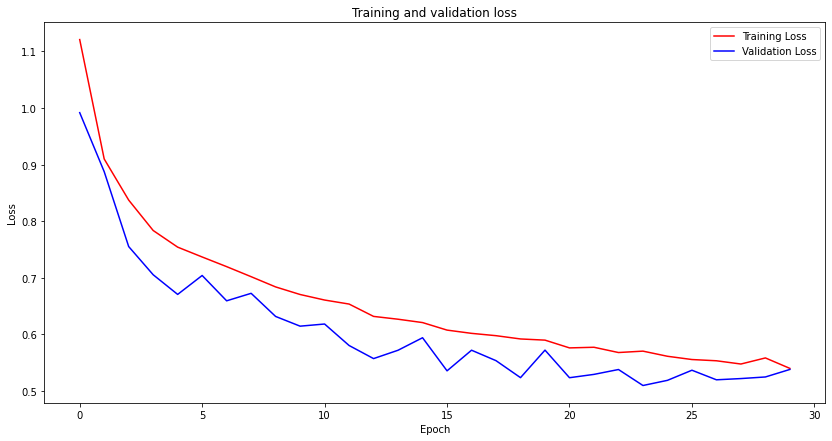

In [51]:
fig2 = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [87]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    print(a.shape)
    a = np.expand_dims(a, axis = 0)
    a /= 255.
    print(a.shape)
    return a

In [88]:
resized_image=preprocess_image("D:\\archive (2)\\COVID-19_Radiography_Dataset\\refined_covid\\27.png")

(256, 256, 3)
(1, 256, 256, 3)


In [79]:
imass=cv2.imread("D:\\archive (2)\\COVID-19_Radiography_Dataset\\refined_covid\\27.png")

In [80]:
imass.shape

(299, 299, 3)

In [59]:
prediction=model.predict(resized_image)

In [64]:
pred=model.predict_classes(resized_image)

In [67]:
def findout(pred):
    if pred==0:
        print('COVID')
    elif pred == 1:
        print('Pneumonia')
    elif pred==2:
        print('Lung_Opacity')
    else:
        print('Normal')

In [68]:
findout(pred)

COVID


In [71]:
model.save("D:\\archive (2)\\COVID-19_Radiography_Dataset\\x-ray\\best.h5")

In [75]:
from keras import models

In [76]:
model1=models.load_model("D:\\archive (2)\\COVID-19_Radiography_Dataset\\x-ray\\best.h5")

In [77]:
findout(model1.predict_classes(resized_image  ))

C:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


COVID
